# Experimentational Notebook

## Import libraries

In [1]:
# Import Simulation libraries
from rlbench.environment import Environment
from rlbench.action_modes import ArmActionMode, ActionMode
from rlbench.observation_config import ObservationConfig, CameraConfig
from rlbench.tasks import MyPickAndLift
from rlbench.gym import RLBenchEnv

# Import NN libraries
from tensorflow.keras.layers import Flatten, Input, Dense, Activation, Concatenate
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam


# Import Reinforcement Learning libraries
from rl.agents.ddpg import DDPGAgent
from rl.random import GaussianWhiteNoiseProcess, OrnsteinUhlenbeckProcess
from rl.memory import SequentialMemory

# Import custom functions and classes
from helper_functions import *
from reward import Reward

# Import support libraries
from typing import Union, Dict, Tuple
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gym
from gym import spaces
from PIL import Image
import pandas as pd
import numpy as np

# Some Tweaks
Adam._name = 'Adam'

## Simulation Setup

In [3]:
# Camera Configuration
camera_configuration = CameraConfig(rgb=True, depth=True, mask=True, image_size=(128, 128))

In [4]:
# Observation Configuration
obs_config = ObservationConfig(left_shoulder_camera = camera_configuration,
                 right_shoulder_camera = camera_configuration,
                 wrist_camera = camera_configuration,
                 front_camera = camera_configuration,
                 joint_velocities=True,
                 joint_positions=True,
                 joint_forces=True,
                 gripper_open_amount=True,
                 gripper_pose=True,
                 gripper_joint_positions=True,
                 gripper_touch_forces=True,
                 record_gripper_closing=True,
                 task_low_dim_state=True)

In [7]:
# Set the action mode to absolute joint velocity
action_mode = ActionMode(ArmActionMode.ABS_JOINT_VELOCITY)

# Initialize the simulation environment
env = Environment(action_mode, obs_config=obs_config, headless=False)
env.launch()

# Load the task
task = env.get_task(MyPickAndLift)

# Reset the environment
descriptions, obs = task.reset()

In [5]:
# Reward object initialization
time_dependant_penalty = True
reward = Reward(task.get_pyrep(), time_dependant_penalty)

/home/valentin/Documents/COMP0138/env/lib/python3.7/site-packages/pyrep/objects/object.py:656: UserWarning: Object (0, 'DefaultCamera') has ObjectType.CAMERA, which is not supported
  'which is not supported'.format(handle, name, type))
/home/valentin/Documents/COMP0138/env/lib/python3.7/site-packages/pyrep/objects/object.py:656: UserWarning: Object (1, 'DefaultXViewCamera') has ObjectType.CAMERA, which is not supported
  'which is not supported'.format(handle, name, type))
/home/valentin/Documents/COMP0138/env/lib/python3.7/site-packages/pyrep/objects/object.py:656: UserWarning: Object (2, 'DefaultYViewCamera') has ObjectType.CAMERA, which is not supported
  'which is not supported'.format(handle, name, type))
/home/valentin/Documents/COMP0138/env/lib/python3.7/site-packages/pyrep/objects/object.py:656: UserWarning: Object (3, 'DefaultZViewCamera') has ObjectType.CAMERA, which is not supported
  'which is not supported'.format(handle, name, type))
/home/valentin/Documents/COMP0138/env

In [6]:
obs_config.left_shoulder_camera.image_size


(128, 128)

In [2]:

import gym
from gym import spaces
from pyrep.const import RenderMode
from pyrep.objects.dummy import Dummy
from pyrep.objects.vision_sensor import VisionSensor
from rlbench.environment import Environment
from rlbench.action_modes import ArmActionMode, ActionMode
from rlbench.observation_config import ObservationConfig

class DebridementEnv(RLBenchEnv):
    metadata = {'render.modes': ['human', 'rgb_array']}
    
    
    def __init__(self, task_class=MyPickAndLift,time_dependant_penalty=False,
                 render_mode: Union[None, str] = 'human'):
        
        self.TOTAL_TIME_STEPS = 5000
        
        self.curr_step = -1
        
        self._render_mode = render_mode
        obs_config = ObservationConfig()
        action_mode = ActionMode(ArmActionMode.ABS_JOINT_VELOCITY)
        self.env = Environment(
            action_mode, obs_config=obs_config, headless=True)
        self.env.launch()
        self.task = self.env.get_task(task_class)
        
        # Reward object initialization
        self.reward = Reward(self.task.get_pyrep(), time_dependant_penalty)

        _, obs = self.task.reset()

        self.action_space = gym.spaces.Box(low=np.array([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 0]),
                                           high=np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1]), dtype=np.float32)
        
        self.action_size = 8
        
        # New Observation Space
        camera_mask = [x.rgb for x in [obs_config.left_shoulder_camera,\
                    obs_config.right_shoulder_camera, obs_config.wrist_camera, obs_config.front_camera]]
        
        total_cameras = sum(camera_mask)
        
        self.observation_space = spaces.Box(low=0, high=1, shape=(128, 128*total_cameras, 3)) 
        

        if render_mode is not None:
            # Add the camera to the scene
            cam_placeholder = Dummy('cam_cinematic_placeholder')
            self._gym_cam = VisionSensor.create([640, 360])
            self._gym_cam.set_pose(cam_placeholder.get_pose())
            if render_mode == 'human':
                self._gym_cam.set_render_mode(RenderMode.OPENGL3_WINDOWED)
            else:
                self._gym_cam.set_render_mode(RenderMode.OPENGL3)
    
    def step(self, action):
        obs, _, __ = self.task.step(action)
        reward = self.reward.return_reward()
        end = self.reward.check_finished()
        return obs, reward, end, {}
    
    def _extract_obs(self, obs) -> Dict[str, np.ndarray]:
        return np.concatenate([obs.left_shoulder_rgb, obs.right_shoulder_rgb,\
                        obs.wrist_rgb, obs.front_rgb], axis=1)


    def render(self, mode='human') -> Union[None, np.ndarray]:
        if mode != self._render_mode:
            raise ValueError(
                'The render mode must match the render mode selected in the '
                'constructor. \nI.e. if you want "human" render mode, then '
                'create the env by calling: '
                'gym.make("reach_target-state-v0", render_mode="human").\n'
                'You passed in mode %s, but expected %s.' % (
                    mode, self._render_mode))
        if mode == 'rgb_array':
            return self._gym_cam.capture_rgb()

    def reset(self) -> Dict[str, np.ndarray]:
        descriptions, obs = self.task.reset()
        del descriptions  # Not used.
        return self._extract_obs(obs)


    def close(self) -> None:
        self.env.shutdown()

In [18]:
observation=obs
np.concatenate([observation.left_shoulder_rgb, observation.right_shoulder_rgb, observation.wrist_rgb, observation.front_rgb], axis=1).shape

(128, 512, 3)

In [3]:
env = DebridementEnv()

/home/valentin/Documents/COMP0138/env/lib/python3.7/site-packages/pyrep/objects/object.py:656: UserWarning: Object (0, 'DefaultCamera') has ObjectType.CAMERA, which is not supported
  'which is not supported'.format(handle, name, type))
/home/valentin/Documents/COMP0138/env/lib/python3.7/site-packages/pyrep/objects/object.py:656: UserWarning: Object (1, 'DefaultXViewCamera') has ObjectType.CAMERA, which is not supported
  'which is not supported'.format(handle, name, type))
/home/valentin/Documents/COMP0138/env/lib/python3.7/site-packages/pyrep/objects/object.py:656: UserWarning: Object (2, 'DefaultYViewCamera') has ObjectType.CAMERA, which is not supported
  'which is not supported'.format(handle, name, type))
/home/valentin/Documents/COMP0138/env/lib/python3.7/site-packages/pyrep/objects/object.py:656: UserWarning: Object (3, 'DefaultZViewCamera') has ObjectType.CAMERA, which is not supported
  'which is not supported'.format(handle, name, type))
/home/valentin/Documents/COMP0138/env

In [13]:
descriptions, obs = env.task.reset()

In [15]:
env._extract_obs(obs).shape

(128, 512, 3)

In [25]:
env.observation_space.shape

(128, 512, 3)

In [30]:
assert len(env.action_space.shape) == 1
nb_actions = env.action_space.shape[0]

# Next, we build a very simple model.
model = Sequential()
actor.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=env.observation_space.shape))
actor.add(MaxPooling3D(pool_size=(2, 2, 2)))
actor.add(BatchNormalization(center=True, scale=True))
actor.add(Dropout(0.5))
actor.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
actor.add(MaxPooling3D(pool_size=(2, 2, 2)))
actor.add(BatchNormalization(center=True, scale=True))
actor.add(Dropout(0.5))
actor.add(Flatten())
actor.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
actor.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
actor.add(Activation('linear'))
print(actor.summary())

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Concatenate()([action_input, flattened_observation])
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

ValueError: Input 0 of layer conv3d_5 is incompatible with the layer: expected ndim=5, found ndim=2. Full shape received: [None, 8]

In [19]:
memory = SequentialMemory(limit=100000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)
agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
agent.fit(env, nb_steps=50000, visualize=True, verbose=1, nb_max_episode_steps=200)

# After training is done, we save the final weights.
agent.save_weights('ddpg_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
agent.test(env, nb_episodes=10, visualize=True, nb_max_episode_steps=200)

Adam
Training for 50000 steps ...
Interval 1 (0 steps performed)


ValueError: Error when checking input: expected flatten_6_input to have 4 dimensions, but got array with shape (1, 1, 128, 512, 3)

In [8]:
env.action_space.shape[0]

8

## Deep Reinforcment Learning Agent Initialization

### Observation Manipulation

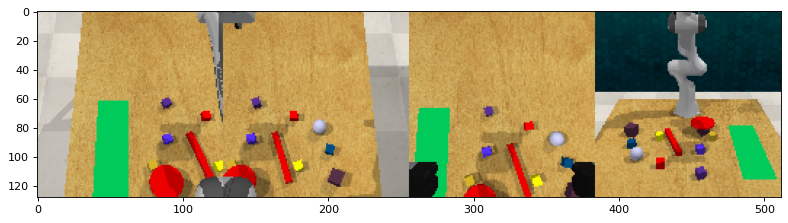

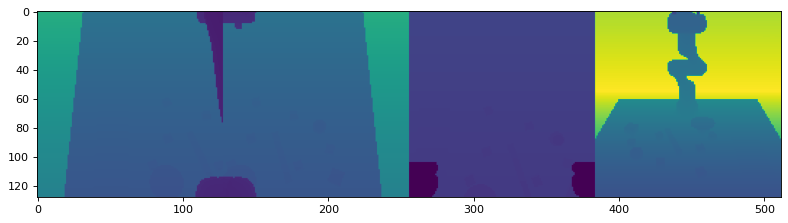

In [6]:
# View the observations
show_observations(obs)

In [5]:
# Reshape the observation
def observation_reshape(obs):
    """
    Stack the depth 2D images as
    a 4th dimension of the 3D RGB
    image.
    """
    return np.dstack((np.concatenate([obs.left_shoulder_rgb, obs.right_shoulder_rgb, obs.wrist_rgb, obs.front_rgb], axis=1),\
                      np.concatenate([obs.left_shoulder_depth, obs.right_shoulder_depth, obs.wrist_depth, obs.front_depth], axis=1)))

In [6]:
print("Stacked RGBD observation space shape: {}".format(observation_reshape(obs).shape))
print("Input dimensionality shape: {}".format(observation_reshape(obs).ravel().shape))

NameError: name 'obs' is not defined

In [9]:
env.observation_space

Box(198,)

In [8]:
obs_shape = observation_reshape(obs).ravel().shape
action_shape = env.action_size

NameError: name 'obs' is not defined

In [21]:
obs_shape=(198,) #env.observation_space
action_shape = (8,) #env.action_space

In [22]:
env.observation_space

Box(198,)

In [4]:
# NEED TO CHANGE!
actor = Sequential()
actor.add(Flatten(input_shape=(1,) + obs_shape))
actor.add(Dense(120))
actor.add(Activation('relu'))
actor.add(Dense(128))
actor.add(Activation('relu'))
actor.add(Dense(128))
actor.add(Activation('relu'))
actor.add(Dense(env.action_size))
actor.add(Activation('linear'))
print(actor.summary())

action_input = Input(shape=(action_shape,), name='action_input')
observation_input = Input(shape=(1,) + obs_shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Concatenate()([action_input, flattened_observation])
x = Dense(128)(x)
x = Activation('relu')(x)
x = Dense(128)(x)
x = Activation('relu')(x)
x = Dense(128)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

NameError: name 'obs_shape' is not defined

In [11]:
nb_actions = (8,)

In [12]:
# NEED TO CHANGE!
memory = SequentialMemory(limit=100000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)

agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)
agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])


Adam


In [9]:
agent.fit(env,  nb_steps=50000, visualize=True, verbose=1, nb_max_episode_steps=200)

NameError: name 'agent' is not defined

In [ ]:
import gym
import rlbench.gym

env = gym.make('reach_target-state-v0', render_mode='human')

training_steps = 120
episode_length = 40
for i in range(training_steps):
    if i % episode_length == 0:
        print('Reset Episode')
        obs = env.reset()
    obs, reward, terminate, _ = env.step(env.action_space.sample())
    env.render()  # Note: rendering increases step time.

print('Done')
env.close()

/home/valentin/Documents/COMP0138/env/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Reset Episode
Reset Episode
Reset Episode
Done


## Training

In [ ]:
training_steps = 120
episode_length = 40
obs = None

In [15]:
for i in range(training_steps):
    if i % episode_length == 0:
        print('Reset Episode')
        descriptions, obs = task.reset()
    action = agent.act(obs)
    #print("Actions: {}".format(action))
    obs, reward, terminate = task.step(action)

Reset Episode
Reset Episode
Reset Episode


In [24]:
print('Done')
env.shutdown()

Done


In [ ]:
agent